In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import feather

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [70]:
def fetch_data(cell_number, type):
    if type == 'charge': prefix = '_c'
    elif type == 'discharge': prefix = '_dc'
    else: prefix = '_imp'

    num = '0' + str(cell_number) if cell_number != 18 else str(cell_number)
    df = feather.read_dataframe('data/B00' + num + prefix + '.feather')
    return df

def get_timeseries(cell_number):
    df = fetch_data(cell_number, 'discharge')
    cap = []
    for i in range(len(df)):
        cap.append(df['data'][i]['Capacity'])

    return cap

def convert_to_usable(ls, scale = True):
    global scaler
    X, Y = [], []

    if scale:
        scaler = MinMaxScaler(feature_range = (0, 1))
        ls = scaler.fit_transform(np.array(ls).reshape(-1,1))

    for i in range(len(ls)-1):
        X.append(ls[i])
        Y.append(ls[i+1])
    #display(pd.DataFrame((X,Y), index = ['X', 'Y']).transpose())
    
    return np.array(X), np.array(Y)

def train_test(ls, test_size = 0.3):
    X, Y = convert_to_usable(ls, True)

    test_len = int(test_size * len(X))
    train_len = len(X) - test_len

    def reshape(arr):
        return arr.reshape(arr.shape[0], 1, 1)

    test = {'X': reshape(X[-test_len:]), 'Y': reshape(Y[-test_len:])}
    train = {'X': reshape(X[:train_len]), 'Y': reshape(Y[:train_len])}

    return train, test

In [71]:
ls = get_timeseries(5)
train, test = train_test(ls)

train_x, train_y = train['X'], train['Y']
test_x, test_y = test['X'], test['Y']

In [107]:
bool(1)

True

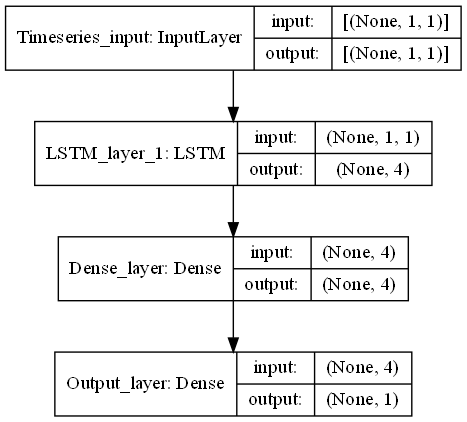

In [119]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM
from keras.utils.vis_utils import plot_model
from tqdm.keras import TqdmCallback

def create_model(lstm_sizes = [4], num_lstm = 1, plot = True):
    bool = False if num_lstm == 1 else True

    input = Input(shape = (1, 1), name = 'Timeseries_input')   
    lstm1 = LSTM(lstm_sizes[0], input_shape = (1, 1), return_sequences = bool, name = "LSTM_layer_1")(input)
    if bool: 
        try: size = lstm_sizes[1]
        except: size = lstm_sizes[0]
        lstm2 = LSTM(size, name = "LSTM_layer_2")(lstm1)

    layer = lstm1 if not bool else lstm2
    dense = Dense(4, activation = None, name = "Dense_layer")(layer)
    if bool: output = Dense(1, name = "Output_layer")(dense)
    else: output = Dense(1, name = "Output_layer")(dense)

    model = Model(inputs = input, outputs = output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    if plot: display(plot_model(model, show_shapes=True, dpi=100))

    return model

model = create_model([4], num_lstm = 1, plot = True)

In [122]:
history = model.fit(train_x, train_y, 
                    epochs = 50, 
                    batch_size = 1, 
                    verbose = 0, 
                    callbacks = [TqdmCallback(verbose = 1, ncols = 100)])

100%|█████████████████████████████████████████████| 50/50 [00:09<00:00,  5.44epoch/s, loss=0.000648]


Train Score: 0.02 RMSE
Test Score: 0.02 RMSE


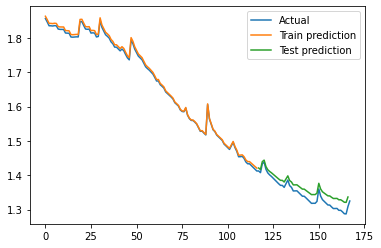

In [124]:
def invert(arr):
    return scaler.inverse_transform(arr)

original = ls
train_pred = invert(model.predict(train_x))
test_pred = invert(model.predict(test_x))
train_true = invert(train_y.reshape(-1,1))
test_true = invert(test_y.reshape(-1,1))

train_RMSE = np.sqrt(mean_squared_error(train_true, train_pred[:,0]))
print(f'Train Score: {train_RMSE:.2f} RMSE')
test_RMSE = np.sqrt(mean_squared_error(test_true, test_pred[:,0]))
print(f'Test Score: {test_RMSE:.2f} RMSE')

train_padding = np.array([np.nan for i in range(len(test_pred))]).reshape(-1,1)
test_padding = np.array([np.nan for i in range(len(train_pred))]).reshape(-1,1)
train_pred = np.vstack((train_pred, train_padding))
test_pred = np.vstack((test_padding, test_pred))

plt.plot(original, label = 'Actual')
plt.plot(train_pred, label = 'Train prediction')
plt.plot(test_pred, label = 'Test prediction')
plt.legend()
plt.show()